In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook # for the progress bar
import cv2
from sklearn.preprocessing import StandardScaler

## 1. Reading the data

In [290]:
import scipy.io
import pandas as pd

mat = scipy.io.loadmat('ex3data1.mat')
X = mat['X']
Y = mat['y']

X.shape, Y.shape

((5000, 400), (5000, 1))

In [291]:
np.random.randint(low=0,high=len(X),size=10)

array([3716,  507, 3062, 3552,  631, 3235, 4791, 3300, 4826, 3773])

/usr/local/lib/python3.6/dist-packages/matplotlib/text.py:1191: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


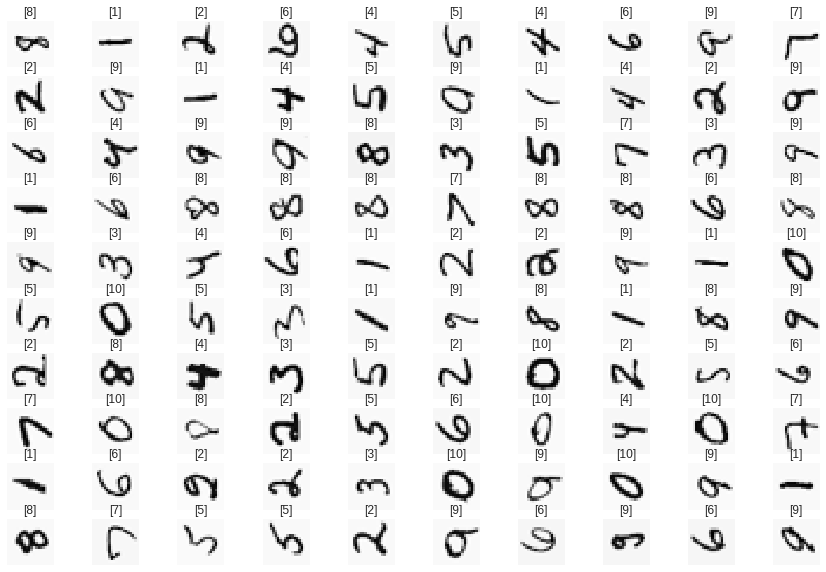

In [321]:
## plots  n by n images at random from the given matrix 
def display_digits(X,Y,n=10):
  
  fig = plt.figure()
  fig.set_size_inches(15,10)

 
  indices = np.random.randint(low=0,high=len(X),size=n*n)  # selects n by n indices at random
  for i,index in enumerate(indices):
    image = X[index,:].reshape((20,20)) # reshape the ravelled image into 20,20 image size
    ax = plt.subplot(n,n,i+1) # plot the image at the particular index 
    ax.imshow(image,origin='lower') 
    ax.set_title(Y[index]) # set the labelled variable from Y matrix
    # turn off both the axis ticks 
    ax.get_xaxis().set_visible(False) 
    ax.get_yaxis().set_visible(False)
    
display_digits(X,Y)

## 2.  Logistic Regression

using multiple one-vs-all logistic regression models to build a multi-class classifier. Since there are 10 classes, you will need to train 10 separate logistic regression classifiers

In [296]:
# add a bias column with value one to capture the intercept
ones= np.ones(shape=(X.shape[0],1))
X1 = np.concatenate((ones,X),axis=1)
m,n = np.shape(X1)

# initialize the learning parameters
theta = np.zeros(shape=(n,1))

X1.shape, theta.shape

((5000, 401), (401, 1))

**Loss function**

$$J(\theta) = \frac{1}{m}\sum_i^n [-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)})) ]$$

**Gradient Descent (Weight Update)**

$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_i^m ((h_\theta(x^{(i)})-y^{(i)}) x^{(i)}_j)$$

In [0]:
# functions 
# 1. Sigmoid function
def sigmoid(x):
  return 1/(1+np.exp(-x))

# 2. error function (Cross Entropy loss)

def loss(theta,X,Y):
  m = X.shape[0]
  log_hypo1 = np.log(sigmoid(np.dot(X,theta)))
  log_hypo2 = np.log(1-sigmoid(np.dot(X,theta)))

  loss = -Y.T@log_hypo1 - (1-Y.T)@log_hypo2
  return 1/m*loss

# 3. Gradient descent weight update
def gradient_descent(theta,X,Y):
  m = X.shape[0]
  hypo = sigmoid(np.dot(X,theta))
  return 1/m*X.T@(hypo - Y)

## 3. Regularized Logistic Regression

**Regularized Loss function**

$$J(\theta) = \frac{1}{m}\sum_i^n [-y^{(i)}log(h_\theta(x^{(i)})) - (1-y^{(i)})log(1-h_\theta(x^{(i)}))] + \frac{\lambda}{2m}\sum_{j=1}^n\theta_j^2$$

** Regularized Gradient Descent (Weight Update)**

$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_i^m ((h_\theta(x^{(i)})-y^{(i)}) x^{(i)}_j) \space for \space j = 0$$
$$\frac{\partial J}{\partial \theta_j} = \frac{1}{m} \sum_i^m ((h_\theta(x^{(i)})-y^{(i)}) x^{(i)}_j) + \frac{\lambda}{m}\theta_j \space for \space j >= 1$$

In [0]:
# regularized functions 
def error(theta,X,Y,lamb):
    hypo = sigmoid(X@theta)
    return 1/m*(-Y.T@np.log(hypo) - (1-Y.T)@np.log(1-hypo)) + lamb/(2*m)*np.sum(np.square(theta))
def my_gradient(theta,X,Y,lamb):
    m,n = np.shape(X)
    theta = theta.reshape(n,1)
    Y = Y.reshape(-1,1)
    grad = (1/m)*X.T@(sigmoid(X@theta)-Y)
    grad[1:] = grad[1:] + lamb/m*theta[1:]
    return grad

## 4. One vs all Classification

In [281]:
# one hot encoding of output Y 
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder(sparse=False)
Y_encode = encoder.fit_transform(Y)
Y_encode.shape

/usr/local/lib/python3.6/dist-packages/sklearn/preprocessing/_encoders.py:371: FutureWarning: The handling of integer data will change in version 0.22. Currently, the categories are determined based on the range [0, max(values)], while in the future they will be determined based on the unique values.
If you want the future behaviour and silence this warning, you can specify "categories='auto'".
In case you used a LabelEncoder before this OneHotEncoder to convert the categories to integers, then you can now use the OneHotEncoder directly.
  warnings.warn(msg, FutureWarning)


(5000, 10)

In [282]:
# output of the model should look like this
Y_encode[0,:]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 1.])

## 5. Trianing the model

for training the model for 10 different classes we have to run the iterations for 10 different times using the logistic classification

In [283]:
Y_encode.shape

(5000, 10)

In [297]:
from scipy.optimize import fmin_tnc
lamb=1
m = theta.shape[0]
n = Y_encode.shape[1]
theta_fit = np.zeros(shape=(m,n))
for i in tqdm_notebook(range(n),total=n,unit='Class'):
  temp = fmin_tnc(func=error, x0 = theta.flatten(), fprime=my_gradient, args=(X1,Y_encode[:,i].ravel(),lamb))
  theta_fit[:,i] = temp[0]
  
theta_fit.shape

(401, 10)

## 6. Predicting the values and evaluation of the output

In [0]:
#def predict(X,theta):
Y_pred = []
output = sigmoid(np.dot(X1,theta_fit))
for row in output:
    predictions = list(row)
    digit = predictions.index(max(predictions))+1
    Y_pred.append(digit)

In [299]:
## evaluation using accuaracy score
from sklearn.metrics import accuracy_score
score = accuracy_score(Y,Y_pred)
score

0.9444